- 작성자: 김명환 (Kim Myunghwan)
- 작성일: 2025년 7월 9일
- 목적: matplotlib.pyplot에서 한글 폰트가 깨지지 않도록 설정한 템플릿
- github: https://github.com/c0z0c/jupyter_hangul
- 환경: Jupyter Notebook 및 Google Colab 겸용
- 자유롭게 편집해서 사용하세요

**한글 폰트 설정 셀**

In [28]:
# coalb 에서는 두번 실행 해야 합니다.
# 첫 번째 실행 - 폰트 설치 후 자동 재시작
# 두번째 실행 - 폰트 설치 완료
# https://github.com/c0z0c/jupyter_hangul
# 코딩 중간에 한글 깨진다 싶으면 helper.setup() 다시 호출 해줘도 됩니다.

from urllib.request import urlretrieve
urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/master/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import helper_c0z0c_dev as helper
print("📁 helper 모듈을 로드했습니다.")
helper.setup()

📁 helper 모듈을 로드했습니다.
🚀 Jupyter/Colab 한글 환경 설정 중... (helper v2.3.0)
Mounted at /content/drive
✅ matplotlib 한글 폰트 설정 완료
✅ 한글 폰트 및 pandas 확장 기능 설정 완료
🎉 사용 가능: 한글 폰트, CSV 읽기, DataFrame.head_att(), 캐시 기능


# >기본< 라이브리 로드

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# --- 다중공선성 진단용 (선택적) ---
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print("statsmodels 라이브러리 로드 완료")
except Exception:
    print("statsmodels 라이브러리가 설치되어 있지 않습니다. 설치: !pip install statsmodels")

# --- 표준 라이브러리 및 유틸리티 ---
import io
import os
import gc
import json
import time
import random
import math
from datetime import datetime, timedelta
import pytz  # 시간대 처리

# --- 이미지 처리 ---
from PIL import Image, ImageDraw, ImageFilter
import cv2  # 필요시 설치: !pip install opencv-python

# --- 데이터/시각화 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from IPython.display import display, Markdown
#from tqdm.auto import tqdm
from tqdm.notebook import tqdm

# --- PyTorch 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split

# --- 선택 패키지(주석) ---
# !pip install pytorch-msssim

# --- 시드 고정 ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# --- 디바이스 및 전역 설정 ---
__kst = pytz.timezone('Asia/Seoul')
global __kst
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global __device
print('Device:', __device)

__model_class_list = []
global __model_class_list
# ...existing code...

statsmodels 라이브러리 로드 완료
Device: cuda


# >기본< 모델링 함수

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import time
import copy
from collections import defaultdict
import numpy as np
from tqdm import tqdm

In [31]:

DEBUG_ON = True if not helper.is_colab else False
# DEBUG_ON = True

# 디바이스 설정 (GPU 사용 가능시 GPU 사용)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"사용 디바이스: {device}")

# CIFAR-10 클래스 이름
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


사용 디바이스: cuda:0


In [32]:

# 데이터 전처리 및 증강
def get_data_transforms():
    # 훈련용 데이터 전처리 (데이터 증강 포함)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # AlexNet 입력 크기에 맞게 리사이즈
        transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])  # ImageNet 평균/표준편차
    ])

    # 검증/테스트용 데이터 전처리
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

In [33]:

# 데이터셋 로드
def load_data():
    train_transform, val_transform = get_data_transforms() # 전처리

    # CIFAR-10 데이터셋 다운로드 및 로드
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform)

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=val_transform)

    # 검증 세트 생성 (훈련 데이터의 20% 사용)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size])

    # 검증 데이터셋에 올바른 transform 적용
    val_dataset.dataset = copy.deepcopy(train_dataset.dataset)
    val_dataset.dataset.transform = val_transform

    # DEBUG_ON이 True면 3개만 사용
    if DEBUG_ON:
        from torch.utils.data import Subset
        train_dataset = Subset(train_dataset, range(3))
        val_dataset = Subset(val_dataset, range(3))
        test_dataset = Subset(test_dataset, range(3))
        batch_size = 3
    else:
        batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)

    print(f"훈련 데이터: {len(train_dataset)}개")
    print(f"검증 데이터: {len(val_dataset)}개")
    print(f"테스트 데이터: {len(test_dataset)}개")

    return train_loader, val_loader, test_loader

# load_data()

In [34]:

# 모델 생성 함수
def create_model(strategy='from_scratch'):
    """
    세 가지 전략으로 AlexNet 모델 생성
    - from_scratch: 처음부터 학습
    - feature_extraction: 특성 추출기로만 사용 (분류기만 학습)
    - fine_tuning: 전체 네트워크 미세조정
    """

    if strategy == 'from_scratch':
        # 처음부터 학습 (가중치 초기화)
        model = models.alexnet(pretrained=False)
        model.classifier[6] = nn.Linear(4096, 10)  # CIFAR-10은 10개 클래스

    elif strategy == 'feature_extraction':
        # 사전 훈련된 모델 로드
        model = models.alexnet(pretrained=True)

        # 특성 추출기 부분의 가중치 고정
        for param in model.features.parameters():
            param.requires_grad = False

        # 분류기의 마지막 층만 CIFAR-10용으로 변경
        model.classifier[6] = nn.Linear(4096, 10)

    elif strategy == 'fine_tuning':
        # 사전 훈련된 모델 로드
        model = models.alexnet(pretrained=True)

        # 분류기의 마지막 층을 CIFAR-10용으로 변경
        model.classifier[6] = nn.Linear(4096, 10)

        # 모든 가중치를 학습 가능하게 설정 (기본값)

    model = model.to(device)

    # 학습 가능한 파라미터 수 계산
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"\n=== {strategy.upper()} 전략 ===")
    print(f"총 파라미터 수: {total_params:,}")
    print(f"학습 가능한 파라미터 수: {trainable_params:,}")
    print(f"학습 가능 비율: {100 * trainable_params / total_params:.1f}%")

    return model

# 훈련 함수
def train_fn(model, train_loader, criterion, optimizer, device, epoch=None, epochs=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    res = {}
    desc = f"Train [{epoch+1}/{epochs}]" if epoch is not None and epochs is not None else "Train"
    tqdm_kwargs = {}
    if not DEBUG_ON:
        tqdm_kwargs['disable'] = False
        tqdm_kwargs['mininterval'] = 10

    for images, labels in tqdm(train_loader, leave=False, desc=desc, position=1, **tqdm_kwargs):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        # criterion이 기본(reduction='mean')이라 가정하여 샘플 기준 누적
        running_loss += loss.item() * batch_size
        _, predicted = torch.max(outputs, 1)
        total += batch_size
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = correct / total if total > 0 else 0.0
    res['loss'] = epoch_loss
    res['acc'] = epoch_acc
    return res

# 검증 함수
def validate_fn(model, val_loader, criterion, device, epoch, epochs):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    res = {}
    desc = f"Val   [{epoch+1}/{epochs}]"
    tqdm_kwargs = {}
    if not DEBUG_ON:
        tqdm_kwargs['disable'] = False
        tqdm_kwargs['mininterval'] = 10

    with torch.no_grad():
        for images, labels in tqdm(val_loader, leave=False, desc=desc, position=1, **tqdm_kwargs):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            total += batch_size
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = correct / total if total > 0 else 0.0
    res['loss'] = epoch_loss
    res['acc'] = epoch_acc
    return res

# 모델링 함수 (훈련 + 검증)
def modeling_fn(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, device):
    history = []
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()
    epoch_start_time = None

    for epoch in tqdm(range(epochs), desc="Epochs", position=0):
        epoch_start_time = time.time()

        train_res = train_fn(model, train_loader, criterion, optimizer, device, epoch=epoch, epochs=epochs)
        val_res = validate_fn(model, val_loader, criterion, device, epoch=epoch, epochs=epochs)

        # 스케줄러 업데이트
        if scheduler:
            scheduler.step()

        res = {
            "epoch": epoch,
            "epochs": epochs,
            "train": train_res,
            "val": val_res,
        }

        history.append(res)

        # 최고 성능 모델 저장
        if val_res['acc'] > best_val_acc:
            best_val_acc = val_res['acc']
            best_model_wts = copy.deepcopy(model.state_dict())

        # 에포크 완료 시간 계산
        epoch_elapsed = time.time() - epoch_start_time

        # 첫 번째 에포크 완료 후 예상 완료 시간 계산
        if epoch == 0 and epochs > 1:
            remaining_epochs = epochs - 1
            estimated_total_time = epoch_elapsed * epochs
            estimated_completion = datetime.now(__kst) + timedelta(seconds=epoch_elapsed * remaining_epochs)
            print(f"첫 에포크 완료 - 예상 완료 시간: {estimated_completion.strftime('%Y-%m-%d %H:%M:%S KST')}")

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_res['loss']:.4f}, "
              f"Train Acc: {train_res['acc']:.4f} | "
              f"Val Loss: {val_res['loss']:.4f}, "
              f"Val Acc: {val_res['acc']:.4f} "
              f"({epoch_elapsed:.1f}s)")

    # 전체 학습 완료 시간
    total_elapsed = time.time() - start_time
    completion_time = datetime.now(__kst)

    # 최고 성능 모델 가중치 로드
    model.load_state_dict(best_model_wts)
    print(f'\n최고 검증 정확도: {best_val_acc:.4f}')
    print(f'전체 학습 시간: {total_elapsed:.1f}초 ({total_elapsed/60:.1f}분)')
    print(f'학습 완료 시간: {completion_time.strftime("%Y-%m-%d %H:%M:%S KST")}')

    return model, history

# 테스트 함수
def test_model(model, test_loader):
    """모델 테스트"""
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 클래스별 정확도 계산
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    accuracy = 100 * correct / total
    print(f'전체 테스트 정확도: {accuracy:.2f}%')

    # 클래스별 정확도 출력
    print('\n클래스별 정확도:')
    for i in range(10):
        if class_total[i] > 0:
            print(f'{classes[i]:>8}: {100 * class_correct[i] / class_total[i]:.1f}%')

    return accuracy


In [35]:

# 히스토리에서 데이터 추출 함수
def extract_history_data(history):
    """히스토리에서 loss와 accuracy 데이터 추출"""
    train_loss = [epoch['train']['loss'] for epoch in history]
    train_acc = [epoch['train']['acc'] for epoch in history]
    val_loss = [epoch['val']['loss'] for epoch in history]
    val_acc = [epoch['val']['acc'] for epoch in history]

    return {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

# 결과 시각화 함수
def plot_training_history(histories, strategies):
    """학습 과정 시각화"""
    plt.figure(figsize=(15, 10))

    colors = ['blue', 'red', 'green']

    # 히스토리 데이터 추출
    extracted_histories = [extract_history_data(history) for history in histories]

    # Loss 그래프
    plt.subplot(2, 2, 1)
    for i, (strategy, history) in enumerate(zip(strategies, extracted_histories)):
        plt.plot(history['train_loss'], color=colors[i], linestyle='-',
                label=f'{strategy} Train', linewidth=2)
        plt.plot(history['val_loss'], color=colors[i], linestyle='--',
                label=f'{strategy} Val', linewidth=2)

    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy 그래프
    plt.subplot(2, 2, 2)
    for i, (strategy, history) in enumerate(zip(strategies, extracted_histories)):
        plt.plot(history['train_acc'], color=colors[i], linestyle='-',
                label=f'{strategy} Train', linewidth=2)
        plt.plot(history['val_acc'], color=colors[i], linestyle='--',
                label=f'{strategy} Val', linewidth=2)

    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 최종 검증 정확도 비교
    plt.subplot(2, 2, 3)
    final_val_accs = [history['val_acc'][-1] for history in extracted_histories]
    bars = plt.bar(strategies, final_val_accs, color=colors, alpha=0.7)
    plt.title('Final Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # 막대 위에 수치 표시
    for bar, acc in zip(bars, final_val_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # 학습 시간 비교 (각 전략별 에포크 수가 같다면)
    plt.subplot(2, 2, 4)
    epochs = len(extracted_histories[0]['train_loss'])
    epoch_range = range(1, epochs + 1)

    for i, (strategy, history) in enumerate(zip(strategies, extracted_histories)):
        # 검증 정확도의 개선 추이
        val_acc_improvement = np.array(history['val_acc']) - history['val_acc'][0]
        plt.plot(epoch_range, val_acc_improvement, color=colors[i],
                marker='o', label=f'{strategy}', linewidth=2, markersize=4)

    plt.title('Validation Accuracy Improvement', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Improvement')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 모델 학습 및 평가 함수
def train_and_evaluate_strategy(strategy, train_loader, val_loader, test_loader, num_epochs=10):
    """특정 전략으로 모델 학습 및 평가"""
    print(f"\n{'='*60}")
    print(f"{strategy.upper()} 전략 시작")
    print(f"{'='*60}")

    # 모델 생성
    model = create_model(strategy)

    # 손실 함수와 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()

    # 전략에 따른 학습률 설정
    if strategy == 'from_scratch':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    else:  # feature_extraction, fine_tuning
        optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

    # 학습률 스케줄러
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 모델 학습
    model, history = modeling_fn(model, num_epochs, train_loader, val_loader,
                               criterion, optimizer, scheduler, device)

    # 테스트 평가
    print(f"\n{strategy.upper()} 테스트 결과:")
    print("-" * 30)
    test_acc = test_model(model, test_loader)

    return model, history, test_acc

DEBUG_ON= False
CIFAR-10 AlexNet 이미지 분류 실습
훈련 데이터: 40000개
검증 데이터: 10000개
테스트 데이터: 10000개

FEATURE_EXTRACTION 전략 시작

=== FEATURE_EXTRACTION 전략 ===
총 파라미터 수: 57,044,810
학습 가능한 파라미터 수: 54,575,114
학습 가능 비율: 95.7%


Train [1/10]:  94%|█████████▎| 1170/1250 [01:11<00:04, 16.29it/s]
                                                                 
Epochs:  10%|█         | 1/10 [01:34<14:08, 94.26s/it]

첫 에포크 완료 - 예상 완료 시간: 2025-08-14 20:19:45 KST
Epoch 1/10 - Train Loss: 0.9096, Train Acc: 0.6945 | Val Loss: 0.6381, Val Acc: 0.7797 (94.3s)



Train [2/10]:  95%|█████████▍| 1182/1250 [01:12<00:04, 16.19it/s]
                                                                 
Epochs:  20%|██        | 2/10 [03:07<12:31, 93.92s/it]

Epoch 2/10 - Train Loss: 0.6789, Train Acc: 0.7649 | Val Loss: 0.5641, Val Acc: 0.8008 (93.7s)



Train [3/10]:  94%|█████████▍| 1177/1250 [01:11<00:04, 16.71it/s]
                                                                 
Epochs:  30%|███       | 3/10 [04:43<11:02, 94.60s/it]

Epoch 3/10 - Train Loss: 0.6286, Train Acc: 0.7797 | Val Loss: 0.5352, Val Acc: 0.8111 (95.4s)



Train [4/10]:  94%|█████████▍| 1177/1250 [01:12<00:04, 16.31it/s]
                                                                 
Epochs:  40%|████      | 4/10 [06:18<09:29, 94.89s/it]

Epoch 4/10 - Train Loss: 0.6036, Train Acc: 0.7900 | Val Loss: 0.5068, Val Acc: 0.8242 (95.3s)



Train [5/10]:  94%|█████████▍| 1180/1250 [01:12<00:04, 16.20it/s]
                                                                 
Epochs:  50%|█████     | 5/10 [07:53<07:54, 94.89s/it]

Epoch 5/10 - Train Loss: 0.5770, Train Acc: 0.7963 | Val Loss: 0.4959, Val Acc: 0.8278 (94.9s)



Train [6/10]:  96%|█████████▌| 1196/1250 [01:12<00:03, 16.23it/s]
                                                                 
Epochs:  60%|██████    | 6/10 [09:26<06:17, 94.27s/it]

Epoch 6/10 - Train Loss: 0.5552, Train Acc: 0.8058 | Val Loss: 0.4881, Val Acc: 0.8292 (93.1s)



Train [7/10]:  92%|█████████▏| 1144/1250 [01:11<00:06, 16.37it/s]
                                                                 
Epochs:  70%|███████   | 7/10 [11:02<04:44, 94.84s/it]

Epoch 7/10 - Train Loss: 0.5467, Train Acc: 0.8091 | Val Loss: 0.4752, Val Acc: 0.8339 (96.0s)



Train [8/10]:  93%|█████████▎| 1164/1250 [01:11<00:05, 16.62it/s]
                                                                 
Epochs:  80%|████████  | 8/10 [12:37<03:09, 94.76s/it]

Epoch 8/10 - Train Loss: 0.5406, Train Acc: 0.8111 | Val Loss: 0.4721, Val Acc: 0.8365 (94.6s)



Train [9/10]:  96%|█████████▌| 1201/1250 [01:13<00:02, 16.41it/s]
                                                                 
Epochs:  90%|█████████ | 9/10 [14:11<01:34, 94.74s/it]

Epoch 9/10 - Train Loss: 0.5284, Train Acc: 0.8150 | Val Loss: 0.4635, Val Acc: 0.8371 (94.7s)



Train [10/10]:  95%|█████████▍| 1182/1250 [01:12<00:04, 16.06it/s]
                                                                  
Epochs: 100%|██████████| 10/10 [15:46<00:00, 94.66s/it]


Epoch 10/10 - Train Loss: 0.5252, Train Acc: 0.8154 | Val Loss: 0.4611, Val Acc: 0.8381 (94.6s)

최고 검증 정확도: 0.8381
전체 학습 시간: 946.6초 (15.8분)
학습 완료 시간: 2025-08-14 20:19:49 KST

FEATURE_EXTRACTION 테스트 결과:
------------------------------


Testing: 100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


전체 테스트 정확도: 83.78%

클래스별 정확도:
   plane: 83.7%
     car: 89.6%
    bird: 77.0%
     cat: 69.2%
    deer: 82.8%
     dog: 78.6%
    frog: 86.4%
   horse: 87.2%
    ship: 92.0%
   truck: 91.3%

FINE_TUNING 전략 시작

=== FINE_TUNING 전략 ===
총 파라미터 수: 57,044,810
학습 가능한 파라미터 수: 57,044,810
학습 가능 비율: 100.0%


Train [1/10]:  89%|████████▉ | 1111/1250 [01:12<00:09, 15.28it/s]
                                                                 
Epochs:  10%|█         | 1/10 [01:39<14:51, 99.00s/it]

첫 에포크 완료 - 예상 완료 시간: 2025-08-14 20:36:40 KST
Epoch 1/10 - Train Loss: 0.7496, Train Acc: 0.7421 | Val Loss: 0.4883, Val Acc: 0.8262 (99.0s)



Train [2/10]:  90%|████████▉ | 1123/1250 [01:12<00:08, 15.48it/s]
                                                                 
Epochs:  20%|██        | 2/10 [03:17<13:11, 98.95s/it]

Epoch 2/10 - Train Loss: 0.4851, Train Acc: 0.8324 | Val Loss: 0.3952, Val Acc: 0.8584 (98.9s)



Train [3/10]:  90%|█████████ | 1129/1250 [01:12<00:07, 15.56it/s]
                                                                 
Epochs:  30%|███       | 3/10 [04:56<11:31, 98.74s/it]

Epoch 3/10 - Train Loss: 0.4208, Train Acc: 0.8556 | Val Loss: 0.3699, Val Acc: 0.8689 (98.5s)



Train [4/10]:  89%|████████▉ | 1116/1250 [01:12<00:08, 15.50it/s]
                                                                 
Epochs:  40%|████      | 4/10 [06:35<09:52, 98.81s/it]

Epoch 4/10 - Train Loss: 0.3813, Train Acc: 0.8672 | Val Loss: 0.3467, Val Acc: 0.8775 (98.9s)



Train [5/10]:  89%|████████▊ | 1109/1250 [01:11<00:09, 15.62it/s]
                                                                 
Epochs:  50%|█████     | 5/10 [08:13<08:13, 98.70s/it]

Epoch 5/10 - Train Loss: 0.3521, Train Acc: 0.8760 | Val Loss: 0.3404, Val Acc: 0.8768 (98.5s)



Train [6/10]:  88%|████████▊ | 1099/1250 [01:11<00:09, 15.52it/s]
                                                                 
Epochs:  60%|██████    | 6/10 [09:53<06:35, 98.96s/it]

Epoch 6/10 - Train Loss: 0.3147, Train Acc: 0.8901 | Val Loss: 0.3096, Val Acc: 0.8903 (99.5s)



Train [7/10]:  86%|████████▋ | 1081/1250 [01:11<00:10, 15.63it/s]
                                                                 
Epochs:  70%|███████   | 7/10 [11:33<04:57, 99.33s/it]

Epoch 7/10 - Train Loss: 0.3074, Train Acc: 0.8932 | Val Loss: 0.3092, Val Acc: 0.8893 (100.1s)



Train [8/10]:  99%|█████████▉| 1243/1250 [01:21<00:00, 15.47it/s]
                                                                 
Epochs:  80%|████████  | 8/10 [13:14<03:19, 99.81s/it]

Epoch 8/10 - Train Loss: 0.2988, Train Acc: 0.8963 | Val Loss: 0.3017, Val Acc: 0.8911 (100.8s)



Train [9/10]:  90%|█████████ | 1128/1250 [01:12<00:07, 15.38it/s]
                                                                 
Epochs:  90%|█████████ | 9/10 [14:52<01:39, 99.43s/it]

Epoch 9/10 - Train Loss: 0.2880, Train Acc: 0.9001 | Val Loss: 0.2991, Val Acc: 0.8951 (98.6s)



Train [10/10]:  91%|█████████ | 1136/1250 [01:12<00:07, 15.54it/s]
                                                                  
Epochs: 100%|██████████| 10/10 [16:30<00:00, 99.07s/it]


Epoch 10/10 - Train Loss: 0.2792, Train Acc: 0.9025 | Val Loss: 0.2942, Val Acc: 0.8961 (97.9s)

최고 검증 정확도: 0.8961
전체 학습 시간: 990.7초 (16.5분)
학습 완료 시간: 2025-08-14 20:36:40 KST

FINE_TUNING 테스트 결과:
------------------------------


Testing: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s]


전체 테스트 정확도: 89.88%

클래스별 정확도:
   plane: 89.7%
     car: 95.4%
    bird: 89.8%
     cat: 78.9%
    deer: 89.4%
     dog: 83.4%
    frog: 93.2%
   horse: 92.9%
    ship: 93.7%
   truck: 92.4%

FROM_SCRATCH 전략 시작

=== FROM_SCRATCH 전략 ===
총 파라미터 수: 57,044,810
학습 가능한 파라미터 수: 57,044,810
학습 가능 비율: 100.0%


Train [1/10]:  90%|████████▉ | 1120/1250 [01:12<00:08, 15.51it/s]
                                                                 
Epochs:  10%|█         | 1/10 [01:38<14:49, 98.84s/it]

첫 에포크 완료 - 예상 완료 시간: 2025-08-14 20:53:27 KST
Epoch 1/10 - Train Loss: 2.2545, Train Acc: 0.1454 | Val Loss: 2.0271, Val Acc: 0.2438 (98.8s)



Train [2/10]:  88%|████████▊ | 1098/1250 [01:11<00:09, 15.64it/s]
                                                                 
Epochs:  20%|██        | 2/10 [03:17<13:09, 98.73s/it]

Epoch 2/10 - Train Loss: 1.8132, Train Acc: 0.3304 | Val Loss: 1.5791, Val Acc: 0.4295 (98.6s)



Train [3/10]:  99%|█████████▉| 1243/1250 [01:22<00:00, 15.10it/s]
                                                                 
Epochs:  30%|███       | 3/10 [04:58<11:37, 99.59s/it]

Epoch 3/10 - Train Loss: 1.5048, Train Acc: 0.4501 | Val Loss: 1.4000, Val Acc: 0.4870 (100.6s)



Train [4/10]:  99%|█████████▉| 1241/1250 [01:21<00:00, 15.45it/s]
                                                                 
Epochs:  40%|████      | 4/10 [06:38<10:00, 100.06s/it]

Epoch 4/10 - Train Loss: 1.3322, Train Acc: 0.5188 | Val Loss: 1.2206, Val Acc: 0.5594 (100.8s)



Train [5/10]: 100%|█████████▉| 1246/1250 [01:21<00:00, 15.30it/s]
                                                                 
Epochs:  50%|█████     | 5/10 [08:19<08:20, 100.18s/it]

Epoch 5/10 - Train Loss: 1.1746, Train Acc: 0.5793 | Val Loss: 1.0561, Val Acc: 0.6144 (100.4s)



Train [6/10]: 100%|█████████▉| 1249/1250 [01:22<00:00, 14.91it/s]
                                                                 
Epochs:  60%|██████    | 6/10 [09:59<06:40, 100.19s/it]

Epoch 6/10 - Train Loss: 0.9983, Train Acc: 0.6462 | Val Loss: 0.9052, Val Acc: 0.6751 (100.2s)



Train [7/10]:  89%|████████▉ | 1110/1250 [01:13<00:09, 15.20it/s]
                                                                 
Epochs:  70%|███████   | 7/10 [11:39<05:00, 100.22s/it]

Epoch 7/10 - Train Loss: 0.9200, Train Acc: 0.6773 | Val Loss: 0.8394, Val Acc: 0.7030 (100.3s)



Train [8/10]: 100%|█████████▉| 1249/1250 [01:22<00:00, 15.10it/s]
                                                                 
Epochs:  80%|████████  | 8/10 [13:19<03:20, 100.16s/it]

Epoch 8/10 - Train Loss: 0.8543, Train Acc: 0.7005 | Val Loss: 0.7879, Val Acc: 0.7155 (100.0s)



Train [9/10]:  88%|████████▊ | 1104/1250 [01:11<00:09, 15.68it/s]
                                                                 
Epochs:  90%|█████████ | 9/10 [14:59<01:39, 99.92s/it] 

Epoch 9/10 - Train Loss: 0.8046, Train Acc: 0.7201 | Val Loss: 0.7360, Val Acc: 0.7425 (99.4s)



Train [10/10]: 100%|█████████▉| 1246/1250 [01:22<00:00, 15.18it/s]
                                                                  
Epochs: 100%|██████████| 10/10 [16:39<00:00, 99.93s/it]


Epoch 10/10 - Train Loss: 0.7587, Train Acc: 0.7357 | Val Loss: 0.7656, Val Acc: 0.7331 (100.1s)

최고 검증 정확도: 0.7425
전체 학습 시간: 999.3초 (16.7분)
학습 완료 시간: 2025-08-14 20:53:38 KST

FROM_SCRATCH 테스트 결과:
------------------------------


Testing: 100%|██████████| 313/313 [00:19<00:00, 16.23it/s]


전체 테스트 정확도: 74.61%

클래스별 정확도:
   plane: 73.5%
     car: 85.5%
    bird: 57.4%
     cat: 62.5%
    deer: 68.3%
     dog: 62.2%
    frog: 83.6%
   horse: 80.8%
    ship: 87.2%
   truck: 85.1%

전체 결과 요약
feature_extraction: 83.78%
     fine_tuning: 89.88%
    from_scratch: 74.61%


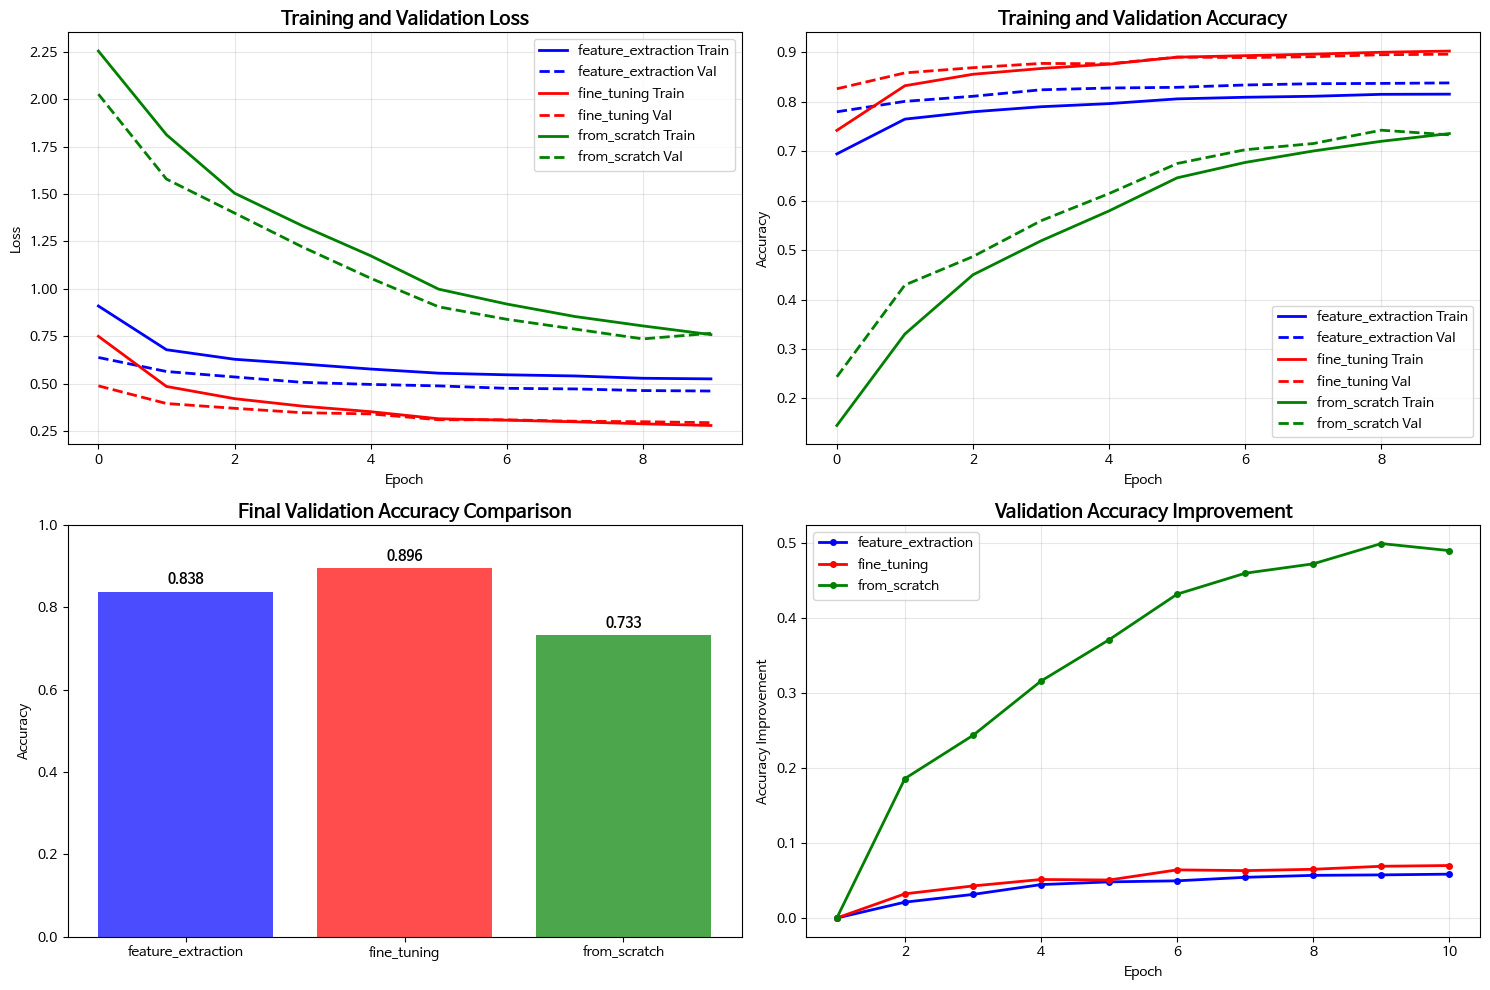


성능 분석 및 권장사항
최고 성능 전략: fine_tuning (89.88%)

각 전략의 특징:
• Feature Extraction: 빠른 학습, 적은 메모리, 제한적 성능
• Fine-tuning: 균형잡힌 성능, 중간 학습시간
• From Scratch: 긴 학습시간, 많은 데이터 필요, 높은 잠재성능
모델 학습 및 평가가 완료되었습니다.


In [36]:
# 메인 실행 함수
def running():
    """메인 실행 함수"""
    print("CIFAR-10 AlexNet 이미지 분류 실습")
    print("=" * 50)

    # 데이터 로드
    train_loader, val_loader, test_loader = load_data()

    # 세 가지 전략
    strategies = ['feature_extraction', 'fine_tuning', 'from_scratch']
    models = []
    histories = []
    test_accuracies = []

    num_epochs = 3 if DEBUG_ON else 10

    # 각 전략별로 모델 학습 및 평가
    for strategy in strategies:
        model, history, test_acc = train_and_evaluate_strategy(
            strategy, train_loader, val_loader, test_loader, num_epochs=num_epochs)

        # 결과 저장
        models.append(model)
        histories.append(history)
        test_accuracies.append(test_acc)

    # 결과 시각화
    print(f"\n{'='*60}")
    print("전체 결과 요약")
    print(f"{'='*60}")

    for strategy, test_acc in zip(strategies, test_accuracies):
        print(f"{strategy:>16}: {test_acc:.2f}%")

    # 학습 과정 시각화
    plot_training_history(histories, strategies)

    # 성능 분석 및 권장사항 출력
    print(f"\n{'='*60}")
    print("성능 분석 및 권장사항")
    print(f"{'='*60}")

    best_strategy = strategies[np.argmax(test_accuracies)]
    print(f"최고 성능 전략: {best_strategy} ({max(test_accuracies):.2f}%)")

    print("\n각 전략의 특징:")
    print("• Feature Extraction: 빠른 학습, 적은 메모리, 제한적 성능")
    print("• Fine-tuning: 균형잡힌 성능, 중간 학습시간")
    print("• From Scratch: 긴 학습시간, 많은 데이터 필요, 높은 잠재성능")

    return models, histories, test_accuracies


print("DEBUG_ON=",DEBUG_ON)
models, histories, test_accuracies = running()
print("모델 학습 및 평가가 완료되었습니다.")

